In [3]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Other imports for processing data
import string
import numpy as np
import pandas as pd

In [20]:
def tokenize_corpus(corpus, num_words=-1):
    # Fit a Tokenizer on the corpus
    if num_words > -1:
        tokenizer = Tokenizer(num_words=num_words)
    else:
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(corpus)
        return tokenizer

def create_lyrics_corpus(dataset, field):
    # Remove all other punctuation
    dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')
    # Make it lowercase
    dataset[field] = dataset[field].str.lower()
    # Make it one long string to split by line
    lyrics = dataset[field].str.cat()
    corpus = lyrics.split('\n')
    # Remove any trailing whitespace
    for l in range(len(corpus)):
        corpus[l] = corpus[l].rstrip()
    # Remove any empty lines
    corpus = [l for l in corpus if l != '']
    return corpus

In [80]:
len(corpus)

43709

In [86]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

In [91]:
len(tokenizer.word_index)

10566

In [74]:
# Read the dataset from csv - this time with 250 songs
dataset = pd.read_csv('../Lyric-Generation-Project/lyric_corpus.csv', dtype=str)[:-1]
# Create the corpus using the 'text' column containing lyrics
corpus = create_lyrics_corpus(dataset, 'Lyrics')
# Tokenize the corpus
tokenizer = tokenize_corpus(corpus, num_words= 2000)
total_words = tokenizer.num_words

# There should be a lot more words now
print(total_words)

<ipython-input-20-ccde557de392>:12: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')


2000


In [43]:
sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        sequences.append(n_gram_sequence)

# Pad sequences for equal input length 
max_sequence_len = max([len(seq) for seq in sequences])
sequences = np.array(pad_sequences(sequences, maxlen=max_sequence_len, padding='pre'))

# Split sequences between the "input" sequence and "output" predicted word
input_sequences, labels = sequences[:,:-1], sequences[:,-1]
# One-hot encode the labels
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [93]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(input_sequences, one_hot_labels, epochs=5, verbose=1)

Epoch 1/5
6955/6955 [==============================] - 773s 111ms/step - loss: 5.6040 - accuracy: 0.0714
Epoch 2/5
6955/6955 [==============================] - 701s 101ms/step - loss: 4.9829 - accuracy: 0.1395
Epoch 3/5
1749/6955 [======>.......................] - ETA: 12:21 - loss: 4.7474 - accuracy: 0.1590

KeyboardInterrupt: 

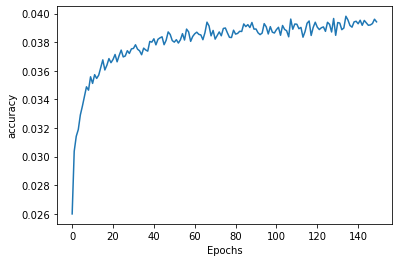

In [94]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

plot_graphs(history, 'accuracy')

In [95]:
seed_text = "im feeling chills"
next_words = 100
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = np.argmax(model.predict(token_list), axis=-1)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

InvalidArgumentError:  indices[0,278] = 3642 is not in [0, 2000)
	 [[node sequential_8/embedding_4/embedding_lookup (defined at <ipython-input-95-db9d428ed0a8>:7) ]] [Op:__inference_predict_function_2316624]

Errors may have originated from an input operation.
Input Source operations connected to node sequential_8/embedding_4/embedding_lookup:
 sequential_8/embedding_4/embedding_lookup/2315729 (defined at /Users/weatherford/opt/anaconda3/envs/learn-env/lib/python3.8/contextlib.py:113)

Function call stack:
predict_function


In [96]:
# Test the method with just the first word after the seed text
seed_text = "im feeling chills"
next_words = 100
  
token_list = tokenizer.texts_to_sequences([seed_text])[0]
token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
predicted_probs = model.predict(token_list)[0]
predicted = np.random.choice([x for x in range(len(predicted_probs))], 
                             p=predicted_probs)
# Running this cell multiple times should get you some variance in output
print(predicted)

InvalidArgumentError:  indices[0,278] = 3642 is not in [0, 2000)
	 [[node sequential_8/embedding_4/embedding_lookup (defined at <ipython-input-95-db9d428ed0a8>:7) ]] [Op:__inference_predict_function_2316624]

Errors may have originated from an input operation.
Input Source operations connected to node sequential_8/embedding_4/embedding_lookup:
 sequential_8/embedding_4/embedding_lookup/2315729 (defined at /Users/weatherford/opt/anaconda3/envs/learn-env/lib/python3.8/contextlib.py:113)

Function call stack:
predict_function


In [97]:
# Use this process for the full output generation
seed_text = "im feeling chills"
next_words = 100
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted_probs = model.predict(token_list)[0]
    predicted = np.random.choice([x for x in range(len(predicted_probs))],
                               p=predicted_probs)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

InvalidArgumentError:  indices[0,278] = 3642 is not in [0, 2000)
	 [[node sequential_8/embedding_4/embedding_lookup (defined at <ipython-input-95-db9d428ed0a8>:7) ]] [Op:__inference_predict_function_2316624]

Errors may have originated from an input operation.
Input Source operations connected to node sequential_8/embedding_4/embedding_lookup:
 sequential_8/embedding_4/embedding_lookup/2315729 (defined at /Users/weatherford/opt/anaconda3/envs/learn-env/lib/python3.8/contextlib.py:113)

Function call stack:
predict_function
